In [1]:
import dask.dataframe as dd

import pandas as pd 


import folium 


import datetime 

import time


import numpy as np

import matplotlib

matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  


import gpxpy.geo 

from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os


mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


import xgboost as xgb


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [3]:
month.head(5)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [4]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

In [5]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

In [6]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())


In [7]:
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    return new_frame
frame_with_durations = return_with_trip_times(month)

In [8]:
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [9]:
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [10]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

<IPython.core.display.Javascript object>


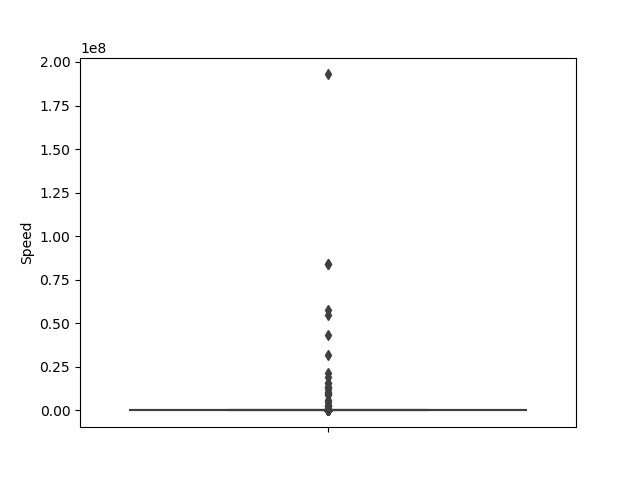

In [11]:
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [12]:
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [13]:
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [14]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [15]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [16]:
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

In [17]:
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [18]:
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [19]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [20]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

In [21]:
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [22]:
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [23]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


In [24]:
#removing all outliers 
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [25]:
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


In [26]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0933194607372518 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7123318236197774 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5179286172497254 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance 

In [27]:
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

In [28]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

<IPython.core.display.Javascript object>


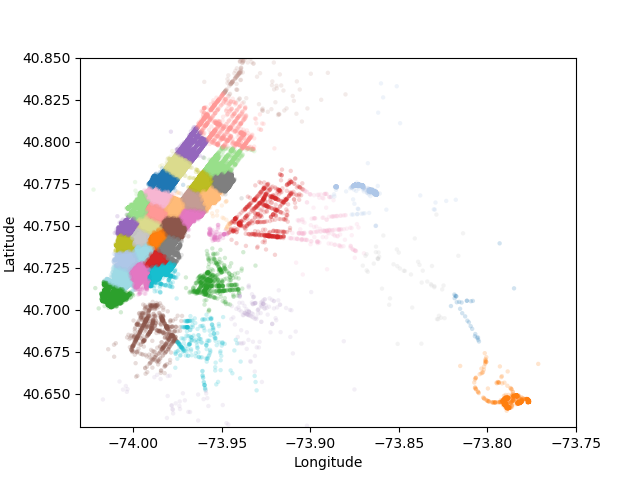

In [29]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

In [30]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
   
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [31]:
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()


In [32]:
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,34,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,2,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,16,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,38,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,22,1419


In [33]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

In [34]:
jan_2015_frame

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,34,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,2,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,16,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,38,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,22,1419
5,1,9.00,-73.874374,40.774048,-73.986977,40.758194,40.33,20.216667,1.420902e+09,26.710635,3,1419
6,1,2.20,-73.983276,40.726009,-73.992470,40.749634,15.30,24.866667,1.420902e+09,5.308311,36,1419
7,3,0.80,-74.002663,40.734142,-73.995010,40.726326,9.96,8.683333,1.420902e+09,5.527831,2,1419
8,3,18.20,-73.783043,40.644356,-73.987595,40.759357,58.13,37.933333,1.420902e+09,28.787346,5,1419
9,2,0.90,-73.985588,40.767948,-73.985916,40.759365,9.35,7.066667,1.420902e+09,7.641509,26,1419


In [35]:
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

In [36]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [37]:
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [38]:
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  1986
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  355
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  38
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  154
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  34
---------

In [39]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [40]:
def smoothing(count_values,values):
    smoothed_regions=[] 
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] 
        repeat=0
        for i in range(4464):
            if repeat!=0: 
                repeat-=1
                continue
            if i in values[r]:
                smoothed_bins.append(count_values[ind]) 
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: 
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                   
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                   
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [41]:
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [42]:
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)
regions_cum = []
for i in range(0,40):
  regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])


In [43]:
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [44]:
def MA_R_Predictions(ratios,month):       #Rt=(Rt−1+Rt−2+Rt−3....Rt−n)/nRt=(Rt−1+Rt−2+Rt−3....Rt−n)/n
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    print(ratios['Prediction'].values)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [45]:
def MA_P_Predictions(ratios,month):      #Pt=(Pt−1+Pt−2+Pt−3....Pt−n)/nPt=(Pt−1+Pt−2+Pt−3....Pt−n)/n
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [46]:
def WA_R_Predictions(ratios,month):       #Rt=(N∗Rt−1+(N−1)∗Rt−2+(N−2)∗Rt−3....1∗Rt−n)/(N∗(N+1)/2)
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [47]:
def WA_P_Predictions(ratios,month):       #Pt=(N∗Pt−1+(N−1)∗Pt−2+(N−2)∗Pt−3....1∗Pt−n)/(N∗(N+1)/2)
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [48]:
def EA_R1_Predictions(ratios,month):          #R′t=α∗Rt−1+(1−α)∗R′t−1Rt′=α∗Rt−1+(1−α)∗Rt−1′
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [49]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [50]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

[  0  63 217 ...  25  34  29]


In [51]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1821155173392136       MSE:  400.0625504032258
Moving Averages (2016 Values) -                        MAPE:  0.14292849686975506        MSE:  174.84901993727598
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.1784869254376018       MSE:  384.01578741039424
Weighted Moving Averages (2016 Values) -               MAPE:  0.13551088436182082       MSE:  162.46707549283155
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.17783550194861494       MSE:  378.34610215053766
Exponential Moving Averages (2016 Values) -         MAPE:  0.135091526

In [52]:
number_of_time_stamps = 5


output = []



tsne_lat = []



tsne_lon = []


tsne_weekday = []


tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [53]:
alpha=0.3


predicted_values=[]

predict_list = []

tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [54]:
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [55]:
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]

test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [56]:
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [57]:
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [58]:
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [59]:
tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [60]:
tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [61]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 9)


In [62]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 9)


In [63]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,118,106,104,93,102,40.776228,-73.982119,4,100
1,106,104,93,102,101,40.776228,-73.982119,4,100
2,104,93,102,101,120,40.776228,-73.982119,4,114
3,93,102,101,120,131,40.776228,-73.982119,4,125
4,102,101,120,131,164,40.776228,-73.982119,4,152


In [64]:
print(np.round(df_test['lat'].iloc[0], 6))

df_test[(np.round(df_test['lat'],6)==40.776228) & (np.round(df_test['lon'],6)==-73.982119)]

40.776228


,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,118,106,104,93,102,40.776228,-73.982119,4,100
1,106,104,93,102,101,40.776228,-73.982119,4,100
2,104,93,102,101,120,40.776228,-73.982119,4,114
3,93,102,101,120,131,40.776228,-73.982119,4,125
4,102,101,120,131,164,40.776228,-73.982119,4,152
5,101,120,131,164,154,40.776228,-73.982119,4,153
6,120,131,164,154,133,40.776228,-73.982119,4,139
7,131,164,154,133,148,40.776228,-73.982119,4,145
8,164,154,133,148,172,40.776228,-73.982119,4,163
9,154,133,148,172,153,40.776228,-73.982119,4,156


In [65]:

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

<IPython.core.display.Javascript object>


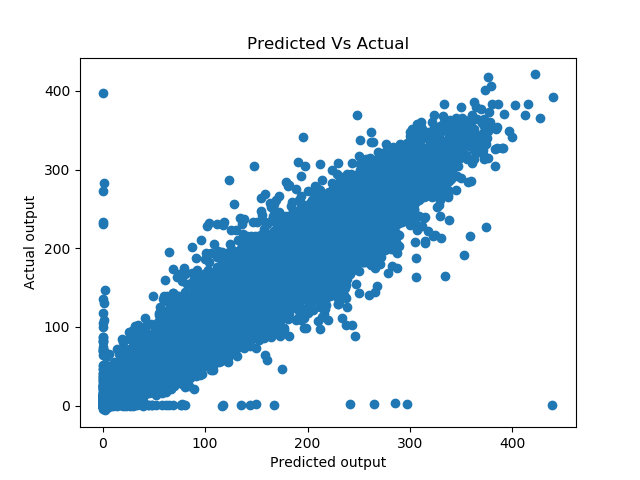

In [95]:
plt.scatter(tsne_test_output,lr_test_predictions)
plt.xlabel("Predicted output")
plt.ylabel("Actual output")
plt.title("Predicted Vs Actual")
plt.show()

In [67]:


regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [68]:


y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

<IPython.core.display.Javascript object>


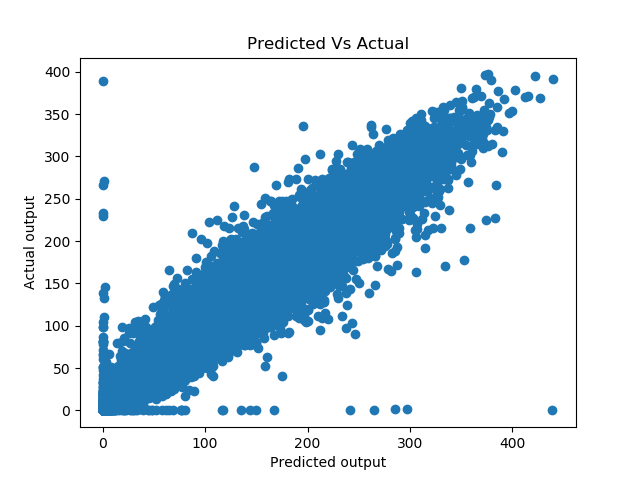

In [69]:
plt.scatter(tsne_test_output,rndf_test_predictions)
plt.xlabel("Predicted output")
plt.ylabel("Actual output")
plt.title("Predicted Vs Actual")
plt.show()

In [70]:

print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.06005015 0.02657728 0.12663153 0.16367399 0.26132902 0.00225668
 0.00240862 0.00162819 0.35544453]


In [71]:

from xgboost import plot_importance

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

<IPython.core.display.Javascript object>


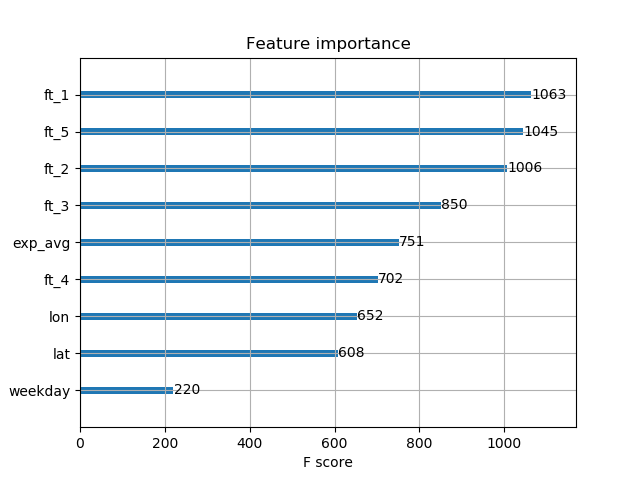

In [72]:
plot_importance(x_model)
plt.show()

In [73]:

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

<IPython.core.display.Javascript object>


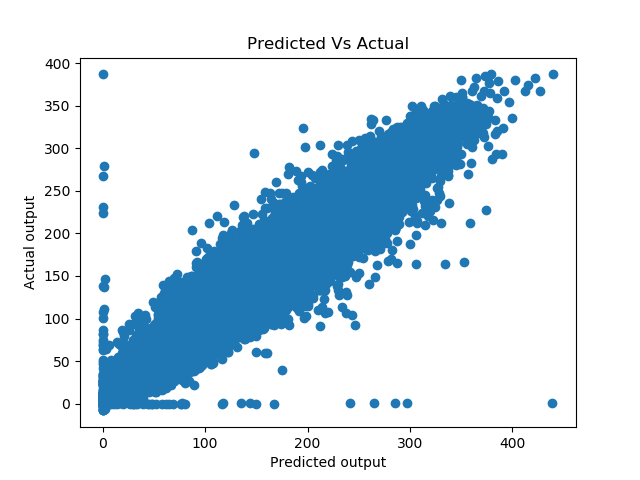

In [74]:
plt.scatter(tsne_test_output,xgb_test_predictions)
plt.xlabel("Predicted output")
plt.ylabel("Actual output")
plt.title("Predicted Vs Actual")
plt.show()

In [75]:
df_test

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,118,106,104,93,102,40.776228,-73.982119,4,100
1,106,104,93,102,101,40.776228,-73.982119,4,100
2,104,93,102,101,120,40.776228,-73.982119,4,114
3,93,102,101,120,131,40.776228,-73.982119,4,125
4,102,101,120,131,164,40.776228,-73.982119,4,152
5,101,120,131,164,154,40.776228,-73.982119,4,153
6,120,131,164,154,133,40.776228,-73.982119,4,139
7,131,164,154,133,148,40.776228,-73.982119,4,145
8,164,154,133,148,172,40.776228,-73.982119,4,163
9,154,133,148,172,153,40.776228,-73.982119,4,156


In [76]:
exp1 = df_test

In [77]:
exp2 = exp1.loc[:, 'lat':'lon']

In [78]:
uni_lat= exp2.lat.unique()

In [79]:
uni_lon= exp2.lon.unique()

In [80]:
uni_lon

array([-73.98211908, -73.79280567, -74.00352811, -73.86925527,
       -73.98707338, -73.78398037, -73.95664097, -73.97596995,
       -73.95533287, -74.01140268, -73.95257907, -73.99686966,
       -73.98797472, -73.92596681, -73.95086273, -73.98752208,
       -73.96854563, -74.00327068, -73.92808536, -73.98182643,
       -73.98793833, -73.97738668, -73.96640954, -73.93263975,
       -73.99619927, -73.96808755, -73.98446841, -73.89242701,
       -73.98040631, -73.95019424, -73.84591186, -73.9957121 ,
       -73.9607757 , -74.0047514 , -73.99105394, -73.97567308,
       -73.9858848 , -73.96151213, -74.00722941, -73.99397696])

In [81]:
uni_lat

array([40.77622761, 40.70666981, 40.72978932, 40.77214498, 40.74203762,
       40.64559111, 40.7677897 , 40.76069483, 40.71589776, 40.70890043,
       40.78449485, 40.76039472, 40.72998264, 40.75679976, 40.80872841,
       40.75747432, 40.79586937, 40.7486285 , 40.69714761, 40.63595171,
       40.68681165, 40.74963916, 40.76380022, 40.84067259, 40.72203367,
       40.75568459, 40.76596417, 40.74756485, 40.73726401, 40.7761468 ,
       40.7198026 , 40.74215029, 40.77544841, 40.73948589, 40.74998674,
       40.7852789 , 40.72229373, 40.67933738, 40.71821166, 40.73420791])

In [82]:
exp2.to_csv('exp2.csv')

In [83]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [84]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.14005275878666593       Test:  0.13653125704827038
Exponential Averages Forecasting -           Train:  0.13289968436017227       Test:  0.12936180420430524
Linear Regression -                         Train:  0.13331572016045437       Test:  0.1291202994009687
Random Forest Regression -                   Train:  0.09185590514224064      Test:  0.12717593247422482
XgBoost Regression -                         Train:  0.12940638535774002       Test:  0.12686666870548835
--------------------------------------------------------------------------------------------------------


In [85]:
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD HH:MM:SS")
    return 1

In [86]:

def predict_number_pickups(lat,lon,time_str):
    if not (((lon <= -74.15) & (lat <= 40.5774)) & ((lon >= -73.7004) & (lat >= 40.9176))):
        if validate(time_str):
            time_str = datetime.datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
            time_str = time.mktime(time_str.timetuple())      
            print("Unix time equivalent to give time ",time_str)
            time_bin = int((time_str-1456770600)/600)        
            if time_bin > 533:
                bin_ix = time_bin-533            
                cluster_center = kmeans.cluster_centers_[kmeans.predict(np.array((lat, lon)).reshape(1,-1))][0]
               
                index_list = df_test.index[(df_test['lat']==cluster_center[0]) & (df_test['lon']==cluster_center[1])].tolist()
                
                df_ix = index_list[bin_ix-1]
                print("Cluster center for the given coordinates",np.round(cluster_center,6))
                print("index in the test data that corresponds to given input", df_ix)
                print('-'*50)
                print("Predicted number of pickups :", int(x_model.predict(df_test[df_test.index == df_ix])[0]))
                print("Orginal number of pickups", tsne_test_output[df_ix])
            else:
                print("You have give the past date to predict, please provide the future time to predict")
    else:
        print("You have given coordinates out of th bounding box of newyork")

In [87]:
 
lat =40.7762276100933
lon =-73.9821190752684


time_str = '2016-03-12 12:12:00'
predict_number_pickups(lat,lon,time_str)

Unix time equivalent to give time  1457764920.0
Cluster center for the given coordinates [ 40.776228 -73.982119]
index in the test data that corresponds to given input 1123
--------------------------------------------------
Predicted number of pickups : 131
Orginal number of pickups 154


In [ ]:
import tkinter as tk 
from tkinter import *
from PIL import ImageTk,Image
        
def predict_number_pickups():
    march = "2016-03-"           #2016-03-05 17:12:00
    secondmarch="00"
    column=":"
    lat=float(entry1.get())
    lon=float(entry2.get())
    daymarch = entry3.get()
    hourmarch = entry4.get()
    minmarch = entry5.get()
   # time_str =  march+daymarch+" "+hourmarch
    time_str =  march+daymarch+" "+hourmarch+column+minmarch+column+secondmarch
    if not (((lon <= -74.15) & (lat <= 40.5774)) & ((lon >= -73.7004) & (lat >= 40.9176))):
        if validate(time_str):
            time_str = datetime.datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
            time_str = time.mktime(time_str.timetuple())
            time_bin = int((time_str-1456770600)/600)
            if time_bin > 533:
                bin_ix = time_bin-533
                cluster_center = kmeans.cluster_centers_[kmeans.predict(np.array((lat, lon)).reshape(1,-1))][0]          
                index_list = df_test.index[(df_test['lat']==cluster_center[0]) & (df_test['lon']==cluster_center[1])].tolist()           
                df_ix = index_list[bin_ix-1]       
                predictmessagestatusText.set('Predicted number of pickups :' + str( int(x_model.predict(df_test[df_test.index == df_ix])[0])))
                statusText.set('Orginal number of pickups :'  + str( tsne_test_output[df_ix]))
            else:
                statusText.set('You have give the past date to predict, please provide the future time to predict')
    else:
        statusText.set('You have given coordinates out of the bounding box of newyork')      
        
        
root = tk.Tk()
def select():
    entry1.delete(0,END)
    entry2.delete(0,END)
    sf = var.get()
    if sf=='Broadway/w 69 St':
       
        lat1=40.7762276100933
        entry1.insert(0,lat1)
        lon1=-73.9821190752684
        entry2.insert(0,lon1)
        root.title('"Broadway/w 69 St" is Selected')
        #return lat1
    elif sf=='168 St/Jamaica Av': 
        lat1=40.706669807434
        lon1=-73.7928056716918
        entry1.insert(0,lat1)
        entry2.insert(0,lon1)
        root.title('"168 St/Jamaica Av" is Selected')
        #return lon1
    elif sf=='28-30 Bedford St': 
        lat=40.72978932
        lon=-74.00352811
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"28-30 Bedford St" is Selected')
    elif sf=='East Elmhurst, Queens': 
        lat=40.77214498
        lon=-73.86925527
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"East Elmhurst, Queens" is Selected')
    elif sf=='Madison Av/E 25 St': 
        lat=40.74203762
        lon=-73.98707338
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Madison Av/E 25 St" is Selected')
    elif sf=='Van Wyck Expy & JFK Access Rd, Jamaica': 
        lat=40.64559111
        lon=-73.78398037
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Van Wyck Expy & JFK Access Rd, Jamaica" is Selected')
    elif sf=='Extell 72nd Street LLC, 330 E 72nd St': 
        lat=40.7677897
        lon=-73.95664097
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Extell 72nd Street LLC, 330 E 72nd St" is Selected')
    elif sf=='5 Av/w 54 St': 
        lat=40.76069483
        lon=-73.97596995
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"5 Av/w 54 St" is Selected')
    elif sf=='85-99 Roebling St': 
        lat=40.71589776
        lon=-73.95533287
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"85-99 Roebling St" is Selected')
    elif sf=='Financial District': 
        lat=40.70890043
        lon=-74.01140268
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Financial District" is Selected')
    elif sf=='135 E 93rd St': 
        lat=40.78449485
        lon=-73.95257907
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"135 E 93rd St" is Selected')
    elif sf=='Armory, 529 W 42nd St': 
        lat=40.76039472
        lon=-73.99686966
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Armory, 529 W 42nd St" is Selected')
    elif sf=='Ukrainian Village': 
        lat=40.72998264
        lon=-73.98797472
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Ukrainian Village" is Selected')
    elif sf=='33-10 35th Ave, Long Island City': 
        lat=40.75679976
        lon=-73.92596681
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"33-10 35th Ave, Long Island City" is Selected')
    elif sf=='Fred Douglass Bl/w 123 St': 
        lat=40.80872841
        lon=-73.95086273
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Fred Douglass Bl/w 123 St" is Selected')
    elif sf=='229 W 43rd St': 
        lat=40.75747432
        lon=-73.98752208
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"229 W 43rd St" is Selected')
    elif sf=='190 W 100th St': 
        lat=40.79586937
        lon=-73.96854563
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"190 W 100th St" is Selected')
    elif sf=='460 W 25th St': 
        lat=40.7486285
        lon=-74.00327068
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"460 W 25th St" is Selected')
    elif sf=='Myrtle Av/Hart St, Brooklyn': 
        lat=40.69714761
        lon=-73.92808536
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Myrtle Av/Hart St, Brooklyn" is Selected')
    elif sf=='1543 42nd St, Brooklyn': 
        lat=40.63595171
        lon=-73.98182643
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"1543 42nd St, Brooklyn" is Selected')
    elif sf=='Boerum Hill, Brooklyn': 
        lat=40.68681165
        lon=-73.98793833
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Boerum Hill, Brooklyn" is Selected')
    elif sf=='Lexington Av/E 40 St': 
        lat=40.74963916
        lon=-73.97738668
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Lexington Av/E 40 St" is Selected')
    elif sf=='153 E 61st St': 
        lat=40.76380022
        lon=-73.96640954
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"153 E 61st St" is Selected')
    elif sf=='Washington Heights': 
        lat=40.84067259
        lon=-73.93263975
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Washington Heights" is Selected')
    elif sf=='Nolita': 
        lat=40.72203367
        lon=-73.99619927
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Nolita" is Selected')
    elif sf=='Midtown East': 
        lat=40.75568459
        lon=-73.96808755
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Midtown East" is Selected')
    elif sf=='316 W 56th St': 
        lat=40.76596417
        lon=-73.98446841
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"316 W 56th St" is Selected')
    elif sf=='Jackson Heights': 
        lat=40.74756485
        lon=-73.89242701
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Jackson Heights" is Selected')
    elif sf=='382 2nd Ave': 
        lat=40.73726401
        lon=-73.98040631
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"382 2nd Ave" is Selected')
    elif sf=='400 E 85 St, 400 E 85th St': 
        lat=40.7761468
        lon=-73.95019424
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"400 E 85 St, 400 E 85th St" is Selected')
    elif sf=='Austin St/70 Rd, Queens': 
        lat=40.7198026
        lon=-73.84591186
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Austin St/70 Rd, Queens" is Selected')
    elif sf=='145 W 20th St': 
        lat=40.74215029
        lon=-73.9957121
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"145 W 20th St" is Selected')
    elif sf=='Upper East Side': 
        lat=40.77544841
        lon=-73.9607757
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Upper East Side" is Selected')
    elif sf=='West Village': 
        lat=40.73948589
        lon=-74.0047514
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"West Village" is Selected')
    elif sf=='W 32 St/7 Av': 
        lat=40.74998674
        lon=-73.99105394
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"W 32 St/7 Av" is Selected')
    elif sf=='155 W 82nd St': 
        lat=40.7852789
        lon=-73.97567308
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"155 W 82nd St" is Selected')
    elif sf=='250 East Houston Street Associates': 
        lat=40.72229373
        lon=-73.9858848
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"250 East Houston Street Associates" is Selected')
    elif sf=='Crown Heights': 
        lat=40.67933738
        lon=-73.96151213
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Crown Heights" is Selected')
    elif sf=='Tribeca': 
        lat=40.71821166
        lon=-74.00722941
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"Tribeca" is Selected')
    elif sf=='51 5th Ave': 
        lat=40.73420791
        lon=-73.99397696
        entry1.insert(0,lat)
        entry2.insert(0,lon)
        root.title('"51 5th Ave" is Selected')
root.geometry("%dx%d+%d+%d" % (530, 220, 500, 550))
root.title("NeW York Taxi Prediction")
var = tk.StringVar(root)
var.set('Broadway/w 69 St')
choices = ['Broadway/w 69 St', '168 St/Jamaica Av', '28-30 Bedford St', 'East Elmhurst, Queens','Madison Av/E 25 St', 'Van Wyck Expy & JFK Access Rd, Jamaica','Extell 72nd Street LLC, 330 E 72nd St','5 Av/w 54 St','85-99 Roebling St','Financial District','135 E 93rd St','Armory, 529 W 42nd St','Ukrainian Village','33-10 35th Ave, Long Island City','Fred Douglass Bl/w 123 St','229 W 43rd St','190 W 100th St','460 W 25th St','Myrtle Av/Hart St, Brooklyn','1543 42nd St, Brooklyn','Boerum Hill, Brooklyn','Lexington Av/E 40 St','153 E 61st St','Washington Heights','Nolita','Midtown East','316 W 56th St','Jackson Heights','382 2nd Ave','400 E 85 St, 400 E 85th St','Austin St/70 Rd, Queens','145 W 20th St','Upper East Side','West Village','W 32 St/7 Av','155 W 82nd St','250 East Houston Street Associates','Crown Heights','Tribeca','51 5th Ave']
option = tk.OptionMenu(root, var, *choices)
option.grid(row=7, column = 0)
button = tk.Button(root, text="Confirm", command=select)
button.grid(row=8, column = 0)

root.bind("<Return>", predict_number_pickups)
predictmessagestatusText = StringVar(root)
statusText = StringVar(root)

L1 = Label(root, text="New York Taxi Prediction",width=25, font = 15)
L1.grid(row=0, column =2)



label = Label(root, text="    ")
L1 = Label(root, text="Latitude")
L1.grid(row=4, column =1 )
L2 = Label(root, text="Longitude")
L2.grid(row=5 ,column =1)
L3 = Label(root, text="Date")
L3.grid(row=6, column =1 )
L4 = Label(root, text="Hour")
L4.grid(row=7, column =1 )
L5 = Label(root, text="Minute")
L5.grid(row=8 ,column =1 )

entry1 = Entry(root, width=50)
entry1.grid(row=4, column =2)
entry2 = Entry(root, width=50)
entry2.grid(row=5, column =2)
entry3 = Entry(root, width=50)
entry3.grid(row=6, column =2)
entry4 = Entry(root, width=50)
entry4.grid(row=7, column =2)
entry5 = Entry(root, width=50)
entry5.grid(row=8, column =2)

predictmessagestatusText.set("Predicted number appears here")
statusText.set("Orginal  number appears here")
b = Button(root, text='Click Me!',command=predict_number_pickups)
b.grid(row=9,column = 2)
predictmessage = Label(root, textvariable=predictmessagestatusText)
predictmessage.grid(column = 2)
#message = Label(root, textvariable=statusText)
#message.grid(column = 2)
root.mainloop()